# Section 3.3 — Introduction to hypothesis testing

This notebook contains the code examples from [**Section 3.3 Introduction to hypothesis testing**]() of the **No Bullshit Guide to Statistics**.

I highly recommend that you use the notebook interactively.
I've intentionally left empty code cells throughout the notebook,
which you can use to try some commands on your own.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from ministats import nicebins

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

### What is hypothesis testing?

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**.
- Hypothesis testing is a standardized procedure for doing statistical analysis
  (also uses stats jargon that makes everything look more convincing ;)

## Definitions

### Hypotheses

- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect.  
  - **Alternative hypothesis $H_A$** = an effect exists.

### Test statistic

An estimator relevant for differentiating $H_0$ from $H_A$.

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

### Sampling distribution of the test statistic under $H_0$

### The p-value

The $p$-value is the probability of observing statistic (or more extreme) under the null hypothesis.

In [6]:
thetas0 = [1,2,3,3,6]

obstheta = 4             # observed value (computed from sample)
th0 = 3                  # parameter under null
obsdev = obstheta - th0  # obs deviation from null

# select the values in the tails of `thetas0`
tails = [v for v in thetas0 if abs(v-th0) >= obsdev]
#######################################################

# compute the proportion in the tails
# = prob of observing "obs or more extreme" value under H0
pvalue = len(tails) / len(thetas0)
pvalue

0.6

The deviation from the parameter `theta0` of 60\% of the values in the list `thetas0`
are equal to or more extreme than the deviation of the observed test statistic $\hat{\theta}_{\mathbf{x}} = \tt{obs}$
form the parameter $\theta_0 = \tt{th0}$.

## The logic of hypothesis testing

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
 - **inputs**: sample statistics computed from the observed data
 - **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

![hypothesis testing overview](./attachments/stats/intro_to_hypothesis_testing.png)


In this notebook, we'll use simulation to obtain the sampling distributions of the test statistic under the null hypothesis.

### Court trial analogy

- defendant innocent <-> null hypothesis
- found guilty <-> reject null
- acquitted <-> fail to reject the null


### Interpreting the result of a hypothesis test

- The implication of rejecting the null hypothesis is that there must be a difference between
  the population from which the sample was taken $X \sim \mathcal{N}(\mu,\sigma)$
  and the theoretical model $X_0 \sim \mathcal{N}(\mu_{X_0},\sigma_{X_0})$.
  - Note that rejecting null hypothesis $H_0$ is not the same as "proving" the alternative hypothesis $H_A$ is true;
    we have just shown that the data is unlikely to occur by chance under the null hypothesis.
  - Using statistics jargon, when we reject the hypothesis $H_0$ we say we've observed a "statistically significant" result,
    which sounds a lot more impressive than it actually is.
    The hypothesis testing procedure is just a simple check we perform to rule out the "occurred by chance" possibility.

- The implication of failing to reject the null hypothesis is that the observed sample could have occurred by chance under $H_0$,
  so there is no need to search for an alternative hypothesis.
  Note that "failing to reject $H_0$" is not the same as "proving" the null hypothesis.

I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it with practice.

### Effect size estimates

The **effect size** $\Delta$ measures the *magnitude* of the deviation of the observed statistic
from the expected theoretical value.
For example,
in a test that compare the sample mean $\overline{\mathbf{x}}$ to a theoretical mean $\mu_{X_0}$,
we can use $\Delta = \mu - \mu_{X_0}$ to measure the deviation of the unknown mean $\mu$ from the theoretical mean $\mu_{X_0}$.
We can obtain an effect size estimate by computing $\widehat{\Delta} = \overline{\mathbf{x}} - \mu_{X_0}$.

Another way to report effect size is to construct a **confidence interval**,
which takes into account the variability of the data.
A confidence interval tells us a range of values where we believe the true value of $\Delta$ falls.
The functions `ci_mean` and `ci_var` from the `ministats` module can help us with confidence interval calculations.

## Simulation tests

Let's start with a description of the problem.
We want to compare a sample of observations from an unknown population to a **fully specified theoretical model**.

TODO: import from text


In [7]:
def gen_sampling_dist(rv, estfunc, n, N=10000):
    """
    Simulate `N` samples of size `n` from the random variable `rv` to
    generate the sampling distribution of the estimator `estfunc`.
    """
    estimates = []
    for i in range(0, N):
        sample = rv.rvs(n)
        estimate = estfunc(sample)
        estimates.append(estimate)
    return estimates

## Test for the mean

We'll now discuss hypothesis tests based on the sample mean.
We're interested in distinguishing between the competing hypotheses:

$$
    H_A: \mu \neq \mu_{X_0}
    \qquad \text{and} \qquad
    H_0: \mu = \mu_{X_0},
$$

where $\mu$ is the mean of the unknown population $X \sim \mathcal{N}(\mu,\sigma)$
from which the sample $\mathbf{x}$ was taken,
and $\mu_{X_0}$ is the mean of the theoretical model $X_0 \sim \mathcal{N}(\mu_{X_0}, \sigma_{X_0})$.

#### Kombucha bottling process

We'll use the kombucha scenario for all the examples in this section.
Recall, the probability distirbution of the kombucha volume is described by
the theoretical model $K_0 \sim \mathcal{N}(\mu_{K_0} = 1000, \sigma_{K_0}=10)$
when the production line is working as expected.

Since $\mu_{K_0}$ and $\sigma_{K_0}$ are known,
we can use simulation to obtain the sampling distribution of any test statistic.

#### Computer model for the kombucha volumes under $H_0$

In [8]:
from scipy.stats import norm

# theoretical model for the kombucha volumes
muK0 = 1000   # theoretical mean
sigmaK0 = 10  # theoretical standard deviation

rvK0 = norm(muK0, sigmaK0)

Let's look at a random sample of size $n=40$ from the distribution under the null hypothesis.

In [9]:
np.random.seed(42)
rvK0.rvs(size=40).round(2)

array([1004.97,  998.62, 1006.48, 1015.23,  997.66,  997.66, 1015.79,
       1007.67,  995.31, 1005.43,  995.37,  995.34, 1002.42,  980.87,
        982.75,  994.38,  989.87, 1003.14,  990.92,  985.88, 1014.66,
        997.74, 1000.68,  985.75,  994.56, 1001.11,  988.49, 1003.76,
        993.99,  997.08,  993.98, 1018.52,  999.87,  989.42, 1008.23,
        987.79, 1002.09,  980.4 ,  986.72, 1001.97])

We can obtain the sampling distribution of the mean by repeatedly generating samples like this,
and computing the mean from each of them.

### Sampling distribution of the mean under the null

We can generate the sampling distribution of the mean $\overline{\mathbf{K}}_0$
by running a simulation using the helper function `gen_sampling_dist`.
We supply three parameters for the simulation:

1. the computer model under $H_0$
2. the estimator function
3. the sample size

In our case, 1. is `rvK0`, 2. is the function `mean`, and 3. `n=40`.

In [10]:
from ministats import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

<Axes: ylabel='Count'>

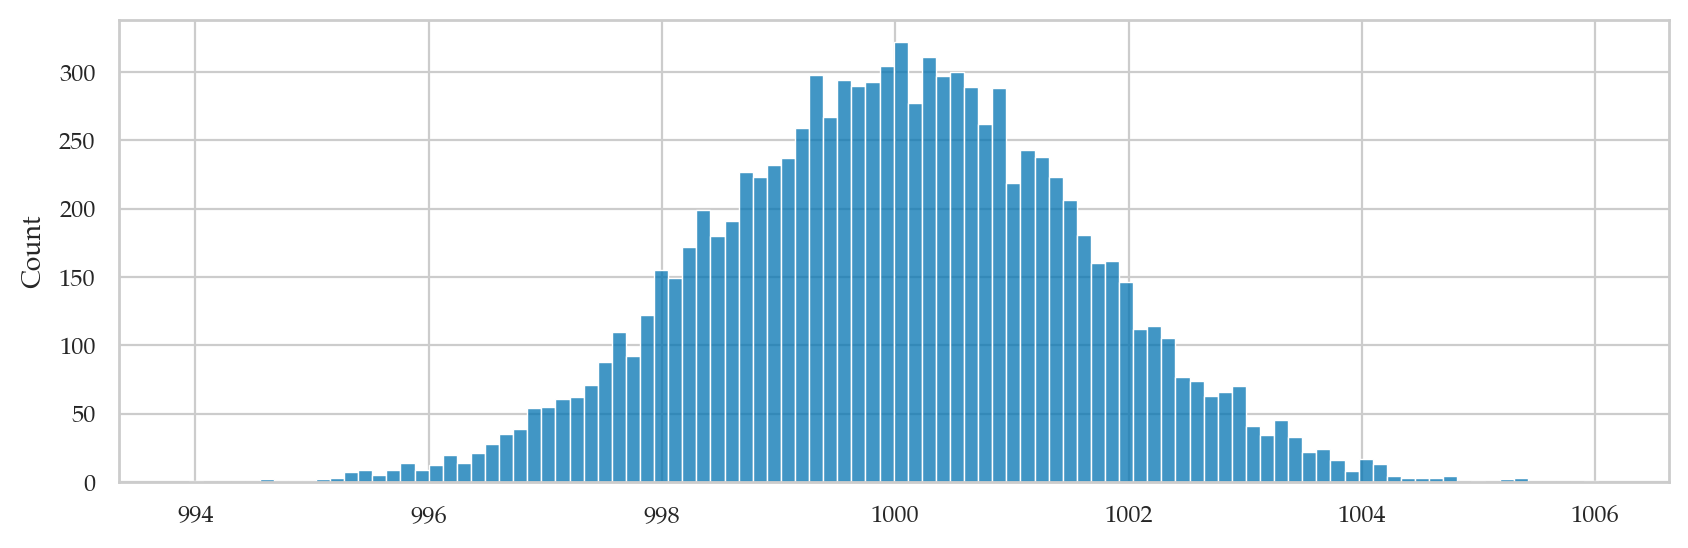

In [11]:
sns.histplot(kbars40, bins=100);

The sampling distribution $\overline{\mathbf{K}}_0 = \tt{kbars40}$
tells us the variability of the sample means we can expect to observe when $H_0$ is true.

### Example 1S: test for the mean of Batch 04

We want to check whether Batch~04 is "regular" or "irregular" by comparing the mean volume of this batch $\mu$
to the mean of the theoretical model $\mu_{K_0} = 1000$\;ml.
We formulate the following competing hypotheses:

$$
    H_A: \mu \neq \mu_{K_0}
    \qquad \text{and} \qquad
    H_0: \mu = \mu_{K_0}.
$$

In words,
the null hypothesis describes a regular batch,
where the mean of the batch is equal to the mean of the model $\mu_{K_0}=1000$.
The two-sided alternative hypothesis states that the mean volume of Batch~04 differs from the expected mean $\mu_{K_0}$,
and it includes both positive or negative deviations.

Let's start by loading the sample $\mathbf{k}_{04}$ from Batch 04 of the `kombucha` dataset.

In [12]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]

In [13]:
len(ksample04)

40

In [14]:
# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

The mean volume calculated from the sample `ksample04` is $3.83$ ml higher than the expected mean $\mu_{K_0} = 1000$ ml.
Is this a big difference or not?
How likely is such deviation to occur by chance under the null hypothesis?

#### Sampling distribution of the mean under the null hypothesis

To answer the above question,
we need to know the sampling distribution of the mean
for samples of size $n=40$ under the null hypothesis $H_0$ (which we just learned how to do above).

Let's run the simulation based on the using the function `gen_sampling_dist` with parameters:

1. probability model `rvK0` $= K_0 \sim \mathcal{N}(\mu_{K_0}=1000,\sigma_{K_0}=10)$
2. the estimator function `mean`
3. the sample size `n = len(ksample04) = 40`

In [15]:
from ministats import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

To calculate the $p$-value,
we want to count how many values of sampling distribution `kbars40`
are equal or more extreme than the observed value $\overline{\mathbf{k}}_{04} =$ `obsmean04` = 1003.8335.

In this context,
"$\overline{\mathbf{k}}_{04}$ or more extreme" means all values whose *deviation* from the mean $\mu_{K_0} = 1000$
is equal to or more extreme than the deviation of the observed mean $\overline{\mathbf{k}}_{04}$ from $\mu_{K_0}$.

Let's start by computing the observed deviation $|\overline{\mathbf{k}}_{04} - \mu_{K_0}|$.

In [16]:
obsdev04 = abs(obsmean04 - muK0)
obsdev04

3.833499999999958

Next we use the list-comprehension syntax to go through the list `kbars40`
and select only the values `v` whose absolute deviation from the mean `abs(v-muK0)`
is equal to or greater than the observe deviation `obsdev04`.

In [17]:
tails = [v for v in kbars40 if abs(v-muK0) >= obsdev04]
tails[0:3]

[1004.786610717458, 995.7701787502498, 995.8232443556451]

The list `tails` contains the subset of the simulated means
that satisfy the "$\overline{\mathbf{k}}_{04}$ or more extreme" condition.

In [18]:
len(tails)

149

Out of the total of $N=10000$ simulated samples under $H_0$,
only 149 satisfy this condition "$\overline{\mathbf{k}}_{04}$ or more extreme." 
That's not a lot!

The $p$-value is computed as  he number of observations in the tails,
divided by the total number of simulated observations.

TODO: mention proportion

In [19]:
pvalue04 = len(tails) / len(kbars40)
pvalue04

0.0149

We can visualize the $p$-value calculation by plotting a histogram of sampling distribution $\overline{\mathbf{K}}_0$
and highlighting the parts of the histogram that satisfy the "$\overline{\mathbf{k}}_{04}$ or more extreme" condition.

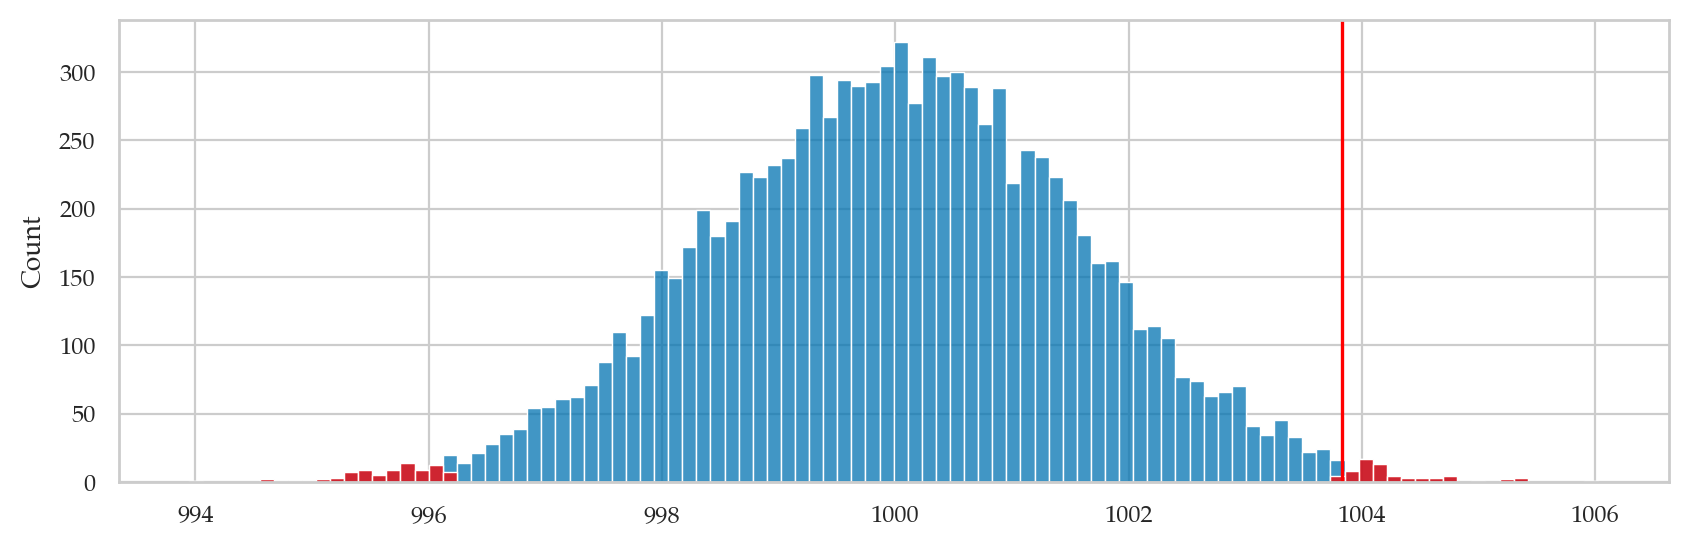

In [20]:
# plot the sampling distribution as a histogram
sns.histplot(kbars40, bins=100)

# plot red line for the observed mean
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=100, color="red");

Note the $p$-value calculation includes simulated observations in the left tail of the distribution:
$\{ \overline{\mathbf{K}}_0 \leq 996.17 \}$.
This is because the alternative hypothesis is stated as $\mu \neq \mu_{K_0}$,
so we must consider both positive and negative deviations.

We can now make the decision by comparing the $p$-value to the pre-determined threshold $\alpha$,
which is conventionally chosen $\alpha=0.05$ (1 in 20).
The $p$-value is 0.015,
which means $\overline{\mathbf{k}}_{04} = 1003.83$ has only a 1.5\% chance of occurring under the null hypothesis.
The $p$-value 0.015 tells us the observed mean `obsmean04` = 1003.8335
is very unlikely to occur by chance under $H_0$,
so our decision is to "reject the null hypothesis."
In other words, Batch 04 is irregular.

#### Effect size estimates

We were able to detect that Batch 04 differs from the expected distribution,
but how big is the deviation?
We can use the deviation from the expected mean $\widehat{\Delta} = \overline{\mathbf{k}}_{04} - \mu_{K_0}$
as an estimate of the effect size in this situation.

In [21]:
mean(ksample04) - muK0

3.833499999999958

The point estimate $\widehat{\Delta} = \overline{\mathbf{k}}_{04} - \mu_{K_0} = 3.83$
tells us how much the mean of the sample differs from the expected population mean $\mu_{K_0}$,
but it doesn't tell us the uncertainty in this estimate.

Let's calculate the 90\% bootstrap confidence interval for the effect size  $\ci{\Delta,0.9}^*$. First let's obtain a 90\% obtain a confidence interval $\ci{\mu,0.9}^*$ for the unknown population mean $\mu$.
We can do this by calling the function `ci_mean` that we defined in Section 3.2
with the options `alpha=0.1` and `method="b"`.

In [22]:
from ministats import ci_mean

np.random.seed(48)
cimu04 = ci_mean(ksample04, alpha=0.1, method="b")
cimu04

[1001.7537499999999, 1005.8020250000002]

We can now convert the confidence interval $\ci{\mu,0.9}^* =$ `cimu04`
to a confidence interval for the effect size by
subtracting the theoretical mean from both limits.

In [23]:
[cimu04[0]-muK0, cimu04[1]-muK0]

[1.7537499999998545, 5.802025000000185]

The confidence interval $\ci{\Delta,0.9}^* = [1.75, 5.80]$ tells us a range of plausible values for the true effect size (how irregular Batch 04 is) could be anywhere between 1.75ml and 5.8ml.
This is much more interesting to know,
since it tells us a whole range of plausible values.
The interval estimate $\ci{\Delta,0.9}^* = [1.75, 5.80]$ takes into account the variability of the samples we used in the calculation.

### Example 2S: test for the mean of Batch 01

Let's repeat simulation test procedure on the sample $\mathbf{k}_{01}$ which comes from Batch 01.

In [24]:
batch01 = kombucha[kombucha["batch"]==1]
ksample01 = batch01["volume"]
len(ksample01)

40

In [25]:
obsmean01 = mean(ksample01)
obsmean01

999.10375

We generate the sampling distribution of the mean for samples of size $n=40$ under the null hypothesis $H_0$ by running a simulation using the function `gen_sampling_dist`.

In [26]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)

Next we computed the observed deviation `obsdev01` $=|\overline{\mathbf{k}}_{01} - \mu_{K_0}|$,
then select the values in `kbars40` whose deviation from $\mu_{K_0}$ is greater than the observed deviation,
and finally compute the $p$-value as the proportion of values in the tails.

In [27]:
obsdev01 = abs(obsmean01 - muK0)
tails = [v for v in kbars40 if abs(v-muK0) >= obsdev01]
pvalue01 = len(tails) / len(kbars40)
pvalue01

0.5711

The large $p$-value tells us that the observed mean $\overline{\mathbf{k}}_{01} = 999.10$ is not unlikely under $H_0$.
Using the terminology of hypothesis testing,
we say the outcome of the hypothesis test is that we *failed to reject* $H_0: \mu = \mu_{K_0}$.
We have not seen any evidence that suggests that the mean of the population from
which sample `ksample01` was taken from differs from the mean of the theoretical model $K_0$.

In other words, Batch 01 is regular. Ship it!

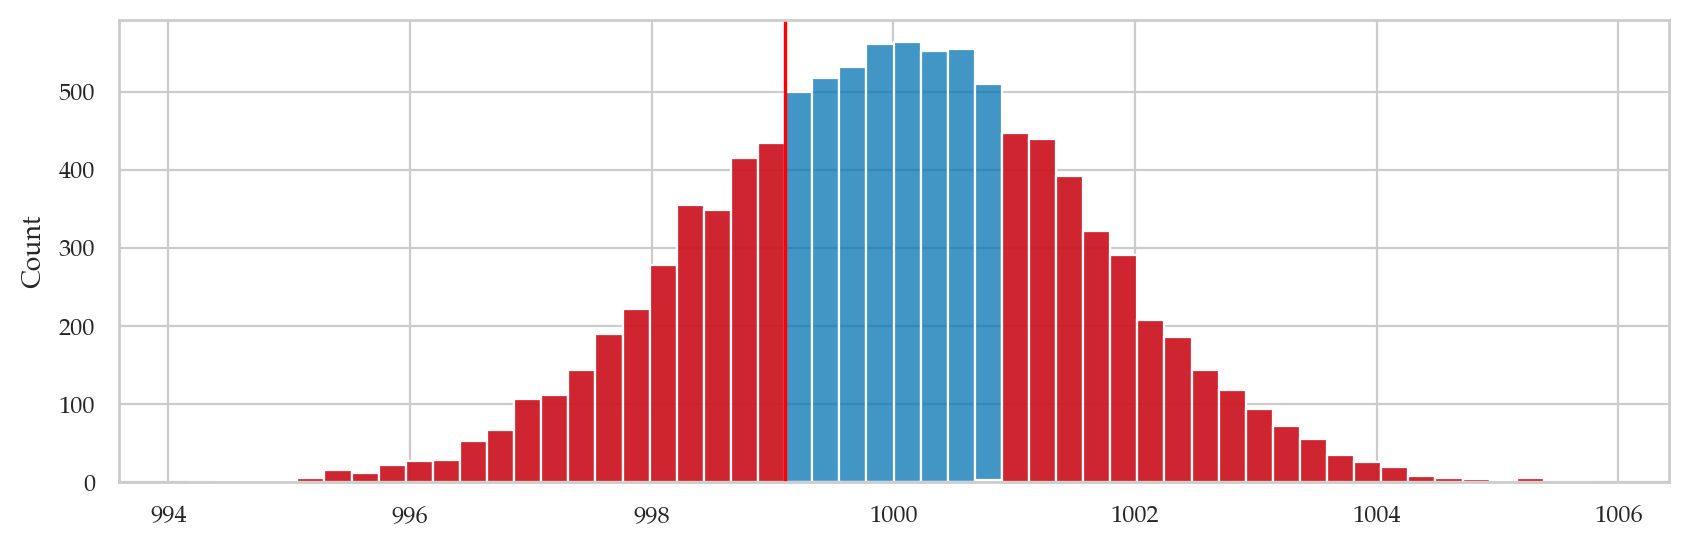

In [28]:
bins = nicebins(kbars40, obsmean01)

# plot the sampling distribution as a histogram
sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean01, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, color="red", bins=bins);

## Test for the variance

#### Sampling distribution of the variance under the null

We can generate the the sampling distribution of the variance $S^2_{\mathbf{K}_0}$
by calling the helper function `gen_sampling_dist`.

In [29]:
from ministats import gen_sampling_dist

np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)

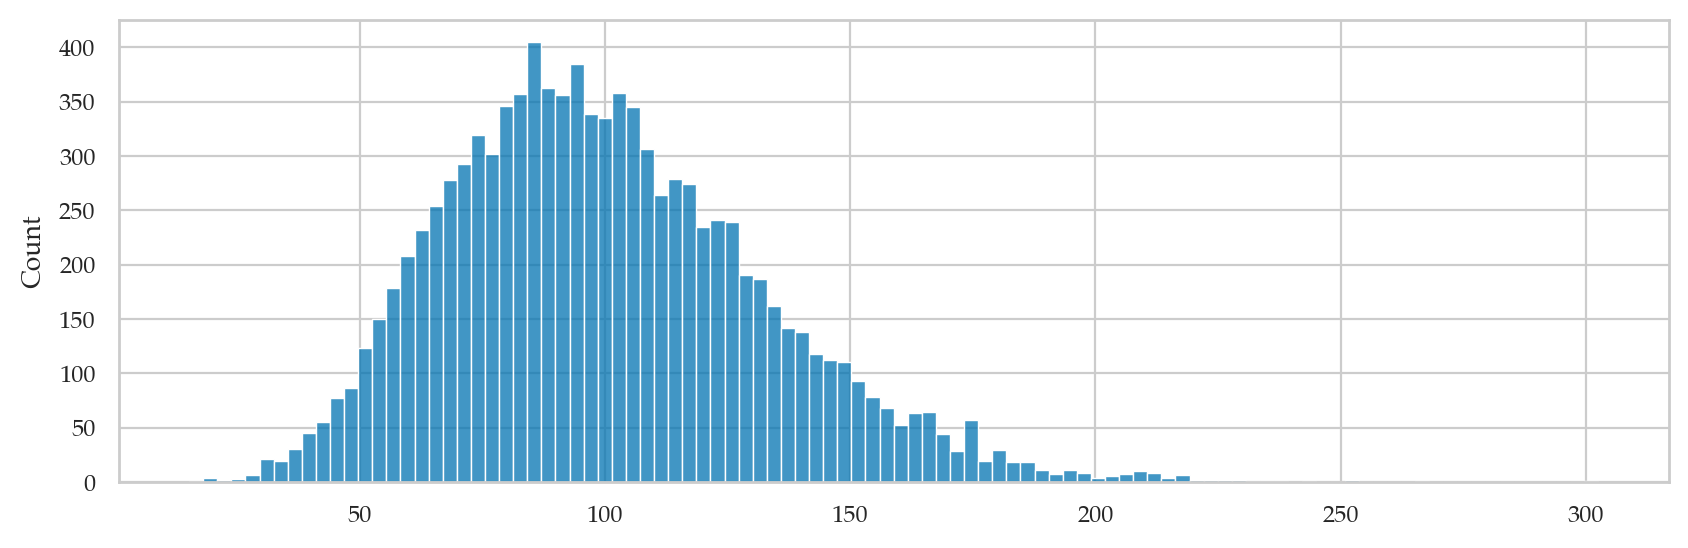

In [30]:
sns.histplot(kvars20, bins=100);

### Example 3S: test for the variance of Batch 02

The sample of volume measurements $\mathbf{k}_{02}$ from the Batch 02 of the kombucha bottling plant comes from an unknown population with variance $\sigma^2$,
which we can estimate by computing the sample variance $s^2_{\mathbf{k}_{02}}$.

We want to check whether Batch 02 is a "regular" or "irregular" by comparing the variance of this batch, $\sigma^2$, to the variance of the theoretical model $\sigma_{K_0}^2= 100$.
Specifically,
we're interested in detecting the case when the variance is higher than expected:

$$
    H_A: \sigma^2 > \sigma_{K_0}^2
    \qquad \text{and} \qquad
    H_0: \sigma^2 \leq \sigma_{K_0}^2.
$$

Note the alternative hypothesis uses the "greater than" inequality,
since we don't mind batches with low variance.

In [31]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
len(ksample02)

20

In [32]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

We'll now generate the sampling distribution of the variance for sample of size $n=20$.

In [33]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)

In [34]:
right_tail = [v for v in kvars20 if v >= obsvar02]
pvalue02 = len(right_tail) / len(kvars20)
pvalue02

0.2132

The $p$-value is greater than the cutoff value $\alpha = 0.05$,
so our decision is "fail to reject $H_0$."

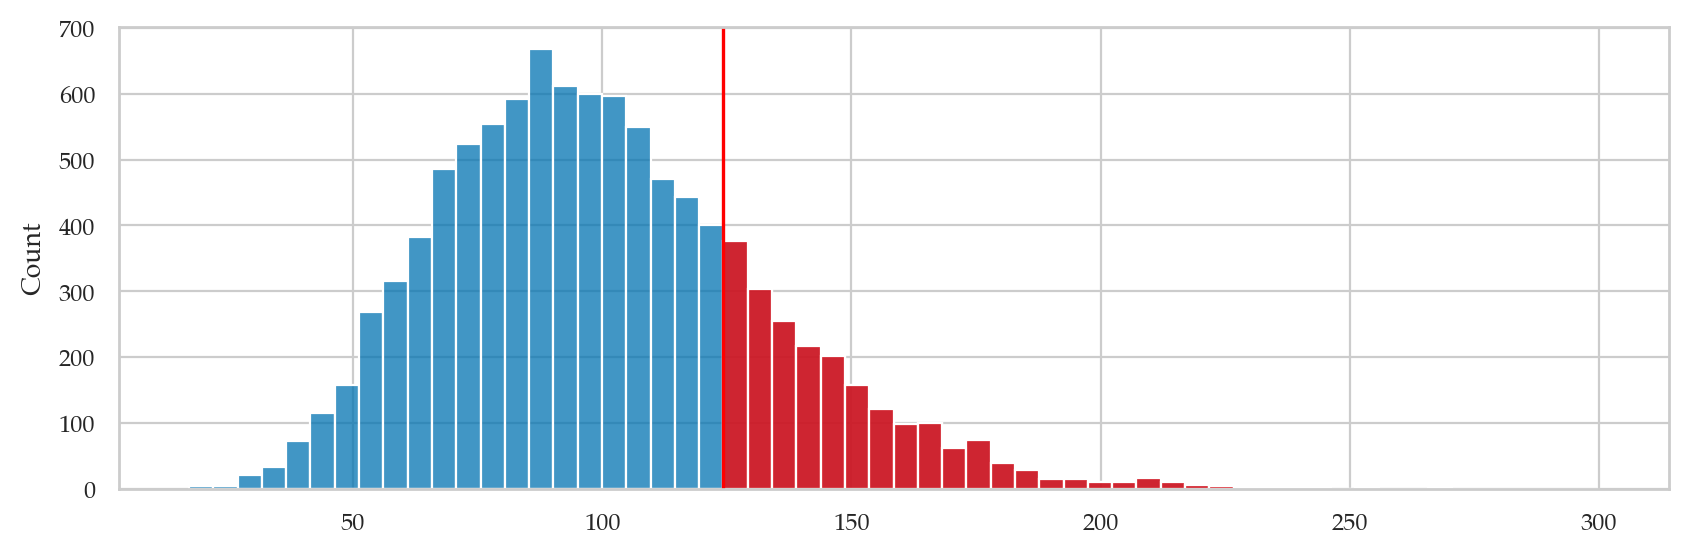

In [35]:
# choose common bins for the histograms
bins = nicebins(kvars20, obsvar02)

# plot sampling distribution
sns.histplot(kvars20, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar02, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(right_tail, bins=bins, color="red");

### Example 4S: test for the variance of Batch 08

In [36]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch08 = kombucha[kombucha["batch"]==8]
ksample08 = batch08["volume"]
len(ksample08)

40

In [37]:
obsvar08 = var(ksample08)
obsvar08

169.9979220512824

We'll now generate the sampling distribution of the variance for sample of size $n=40$.

In [38]:
np.random.seed(43)
kvars40 = gen_sampling_dist(rvK0, estfunc=var, n=40)

In [39]:
right_tail = [v for v in kvars40 if v >= obsvar08]
pvalue08 = len(right_tail) / len(kvars40)
pvalue08

0.0041

The $p$-value is very small,
so our decision is to reject $H_0$.

#### Effect size estimates

We found the variance in the volumes in this batch is higher than the expected variance.
Now let's compute an estimate for the effect size $\widehat{\Delta} = s^2_{\mathbf{k}_{08}} / \sigma_{K_0}^2$.

In [40]:
var(ksample08) / sigmaK0**2

1.699979220512824

This tells us the variance of $\mathbf{k}_{08}$ is 70\% higher in the theoretically expected variance $\sigma_{K_0}^2 = 100$.

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.
We can obtain $\ci{\Delta,0.9}^*$ by first computing a 90\% bootstrap confidence interval
for the variance $\ci{\sigma^2,0.9}^*$.

In [41]:
from ministats import ci_var

np.random.seed(48)
civar08_boot = ci_var(ksample08, alpha=0.1, method="b")
civar08_boot

[117.37369362820536, 217.98659930448775]

We can obtain a confidence interval for 
$\Delta = \sigma^2 / \sigma_{K_0}^2$
by dividing the limits of $\ci{\sigma^2,0.9}^*$ by the theoretical variance $\sigma_{K_0}^2$.

In [42]:
ci_l = civar08_boot[0] / sigmaK0**2
ci_u = civar08_boot[1] / sigmaK0**2
[ci_l, ci_u]

[1.1737369362820536, 2.1798659930448774]

The interval $\ci{\Delta,0.9}^* = [1.17, 2.18]$ tells us the observed sample variance
in Batch 08 is somewhere between 1.17 and 2.18 times the expected variance $\sigma_{K_0}^2$ under the null hypothesis.

## Explanations

### One-sided and two-sided tests

#### Selecting the tails of a distribution

The concept of statistics that are "equal or more extreme than $\hat{\theta}_{\mathbf{x}}$"
is essential to the logic of hypothesis testing.
We'll need to perform this type of filtering any time we use numerical methods for hypothesis testing.

Let's write a helper function that performs the selection of the tail values for us.

In [43]:
def tailvalues(valuesH0, obs, alt="two-sided"):
    """
    Select the subset of the elements in list `valuesH0` that
    are equal or more extreme than the observed value `obs`.
    """
    assert alt in ["greater", "less", "two-sided"]
    valuesH0 = np.array(valuesH0)
    if alt == "greater":
        tails = valuesH0[valuesH0 >= obs]
    elif alt == "less":
        tails = valuesH0[valuesH0 <= obs]
    elif alt == "two-sided":
        meanH0 = np.mean(valuesH0)
        obsdev = abs(obs - meanH0)
        tails = valuesH0[abs(valuesH0-meanH0) >= obsdev]
    return tails

You should be familiar with the three types of tail values selections:

- For right-tailed tests,
  we call `tailvalues` with the option `alt="greater"`,
  which will select the subset of values in the list
  `valuesH0` that are equal to or greater than the observed statistic `obs`.
- Foe left-tailed test,
  we call `tailvalues` with the option `alt="less"`,
  which selects the values that are equal to or less than the observed statistic `obs`.
- For two-tailed tests,
  we select values observations whose deviation from the mean `meanH0`
  is equal to or greater than the observed deviation `obsdev`.

#### One-sided $p$-value calculation example

We can verify that  the function `tailvalues` works as expected
by reproducing the $p$-value calculation from Example 3S.
Reusing the variables `n02=20` and $\tt{obsvar02} = s_{\mathbf{k}_{02}}^2 = 124.32$ we calculated above,
we can obtain the $p$-value by calling the helper function `tailvalues` with the option `alt="greater"`,then dividing by the total number of simulations:

In [44]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK0, estfunc=var, n=20)
tails = tailvalues(kvars20, obsvar02, alt="greater")
pvalue = len(tails) / len(kvars20)
pvalue

0.2132

The result is identical to the $p$-value $\tt{pvalue02} = 0.2132$ that we computed in Example 3S,
so we know the function `tailvalues` works as expected for $p$-value calculations of type **(a)**,
where we want to detect positive deviations from the expected distribution under $H_0$.

#### Two-sided $p$-value calculation example

Reusing the values `n04=40` and $\tt{obsmean04} = \overline{\mathbf{x}}_{04} = 1003.83$
that we calculated earlier in Example 1S,
we can obtain the $p$-value by calling the function `tailvalues`
with the option `alt="two-sided"` then divide by the total number of simulations:

In [45]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK0, estfunc=mean, n=40)
tails = tailvalues(kbars40, obsmean04, alt="two-sided")
pvalue = len(tails) / len(kbars40)
pvalue

0.015

The result is identical to the $p$-value that we obtained in Example 1S,
so we know the function `tailvalues` works as expected for $p$-value calculations of type **(c)**,
where we want to detect both positive and negative deviations from the expected distribution under $H_0$.

### Summary of the hypothesis testing procedure


The steps of the hypothesis testing procedure are as follows:

- Step 1: Formulate two competing hypotheses $H_0$ and $H_A$.
- Step 2: Choose an estimator relevant for distinguishing between the two hypotheses.
- Step 3: Compute the test statistic $\hat{\theta}_{\mathbf{x}}$ from the sample $\mathbf{x}$.
- Step 4: Obtain $\widehat{\Theta}_0$, the sampling distribution of the test statistic under the null hypothesis.
- Step 5: Decide whether to *reject* or *fail to reject* the null hypothesis $H_0$
  based on the $p$-value computed from the observed test statistic $\hat{\theta}_{\mathbf{x}}$
  under the sampling distribution $\widehat{\Theta}_0$ assuming $H_0$ is true.
- Step 6: Report your decision and calculate effect size estimates.

## Discussion

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.
Cohen's $d$ is one such measure, and it is defined as the difference between the observed mean and an expected mean,
divided by the sample standard deviation:

$$
  d = \frac{\overline{\mathbf{x}} - \mu_0}{ s_{\mathbf{x}} }.
$$

For example,
the sample $\mathbf{k}_{04}$ from Batch 04 has mean $\overline{\mathbf{k}}_{04} = 1003.83$,
which corresponds to a "raw" deviation of $3.83$ from the expected value $\mu_{K_0}=1000$.
We divide the raw deviation ($\overline{\mathbf{k}}_{04} - \mu_{K_0}$) by the sample's standard deviation $s_{\mathbf{k}_{04}}= 7.85$
to obtain Cohen's $d$ standardized effect size.

In [46]:
std04 = np.sqrt(var(ksample04))
(mean(ksample04) - muK0) / std04

0.4882087345321637

We can interpret the value of Cohen's $d$ obtained using this [table of reference values](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d),
which was published in (Cohen YYYY TODO) and continues to be used as a reference to this day.

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


The standardized effect size for kombucha Batch 04 is $d=0.488$,
which we quantify as "medium" effect size according to the table of reference values.

The following helper function shows how to compute the Cohen's $d$ for a given sample.

In [47]:
def cohend(sample, mu0):
    """
    Cohen's d for one group compared to the theoretical mean `mu0`.
    """
    obsmean = mean(sample)
    obsstd = np.sqrt(var(sample))
    d = (obsmean - mu0) / obsstd
    return d

In [48]:
cohend(ksample04, mu0=1000)

0.4882087345321637

## Exercises

In [49]:
# TODO

## Links

* \[TALK\] [*Statistics for Hackers*](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by Jake Vanderplas
* \[VIDEO\] [*There's Only One Test*](https://www.youtube.com/watch?v=S41zQEshs5k) by Allen B. Downey
* \[PAPER\] [*The Introductory Statistics Course: A Ptolemaic Curriculum*](https://minireference.com/blog/wp-content/uploads/2021/03/TheIntroductoryStatisticsCourse__Cobb.pdf) by George W. Cobb
* \[PAPER\] [*What Teachers Should Know About the Bootstrap: Resampling in the Undergraduate Statistics Curriculum*](https://www.tandfonline.com/doi/full/10.1080/00031305.2015.1089789) by Tim C. Hesterberg  
* \[BOOK\] [*Think Stats 2e*](https://greenteapress.com/wp/think-stats-2e/) by Allen B. Downey  
